# Tile_tiff Introduction, set up

https://en.wikipedia.org/wiki/Gauss%E2%80%93Boaga_projection
## Problem:
Some geotiffs are too large to be processed. For example, Azure Cognitive Services can process up to a 4mb tiff on the free tier or 50mb on the paid tier. The example tiff is 90 mb.

## Function:
This program takes a large geotiff and divides it into smaller geotiff tiles.

## Inputs:
Georeferenced map. Get the CRS and plan what CRS will be used. 

## Outputs:
A set of smaller geo referenced tifs (tiles)
tile_polys.shp - an outline of where the tiles are.

## Validation
* When done, open the tile_polys.shp and map in QGIS to make sure the area looks correct and no CRS error has been made.
* Check that the right tiles have been selected in the plot below.



In [1]:
!pip install rasterio
!pip install geopandas

     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 1.0 MB 3.9 MB/s 
     |████████████████████████████████| 16.7 MB 429 kB/s 
     |████████████████████████████████| 6.3 MB 42.9 MB/s 


# Class Tile_tiff

In [48]:
import rasterio
import rasterio.plot
import gdal
import osr
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import gdalnumeric
import cv2
import os

class Tile_tiff:

    # class attribute
    tiff_to_tile_path = "" # the source tiff to be split into tiles
    tt_tile_path = "/content/" # the path to where the tiles are saved   

    # varables for gdal    
    tt_gdal_dataset = ""
    tt_srs = ""
    tt_cols = 0
    tt_rows = 0

    # varables for rasterio
    tt_raterio_dataset = 0
    tt_crs = 0
    tt_crs_int = 0
    tt_left_min_x = 0
    tt_bottom_min_y = 0
    tt_right_max_x = 0
    tt_top_max_y = 0
    tt_coords = 0
    tt_pixel_size_x = 0
    tt_pixel_size_y = 0

    # set this for tile size
    tt_tile_pixel_width = 1000
    tt_tile_pixel_height = 1000

    # set this for overlap
    tt_tile_pixel_width_overlap = 0 # 200
    tt_tile_pixel_height_overlap = 0 # 100

    tt_tile_matrix = []
    # gdal
    tt_gdal_driver = ""
    tt_gdal_dataset = ""
    tt_gdal_dataset_band = ""
    tt_gdal_transform = ""
    tt_gdal_data = ""

    tt_wkt = ""


    def create_tile_matrix(self):
        self.tt_tile_matrix = []
        number_tiles_wide = int(self.tt_cols/(self.tt_tile_pixel_width - self.tt_tile_pixel_width_overlap))+1
        number_tiles_high = int(self.tt_rows/(self.tt_tile_pixel_height - self.tt_tile_pixel_height_overlap))+1
        print("create_tile_matrix", number_tiles_wide,number_tiles_high)    
        # rows
        for tif_rows in range(0, number_tiles_high):
            # columns
            for tif_cols in range(0, number_tiles_wide):

                lrx = 0 + ((self.tt_tile_pixel_width - self.tt_tile_pixel_width_overlap) * tif_cols)  # self.tt_left_min_x
                lry = 0 + ((self.tt_tile_pixel_height - self.tt_tile_pixel_height_overlap) * tif_rows)  # self.tt_bottom_min_y

                ulx = lrx + self.tt_tile_pixel_width
                uly = lry + self.tt_tile_pixel_height
                if(lrx>self.tt_cols):
                    lrx=self.tt_cols
                
                if(lry>self.tt_rows):
                    lry=self.tt_rows
                
                if(ulx>self.tt_cols):
                    ulx=self.tt_cols
                
                if(uly>self.tt_rows):
                    uly=self.tt_rows
                
                self.tt_tile_matrix.append([[lrx, lry], [ulx, uly], [tif_cols,tif_rows]])

        return(self.tt_tile_matrix)
    
    def create_tile_files(self):
        self.tt_boundary_polys = gpd.GeoDataFrame()
        self.tt_boundary_polys['geometry'] = None
        self.tt_boundary_polys.crs = (self.tt_wkt)
        self.tt_boundary_polys.geometry = self.tt_boundary_polys.geometry.to_crs(self.tt_wkt)
        self.tt_boundary_polys.to_crs(self.tt_wkt)
        self.tt_boundary_polys = self.tt_boundary_polys.to_crs(self.tt_wkt)
        for tile in self.tt_tile_matrix:
            minx = tile[0][0]
            maxx = tile[1][0]
            miny = tile[0][1]
            maxy = tile[1][1]

            tilex = "00"+str(tile[2][0])
            tilex = tilex[-2:]
            tiley = "00"+str(tile[2][1])
            tiley = tiley[-2:]

            self.tt_gdal_data = self.tt_gdal_dataset_band.ReadAsArray(minx, miny, maxx-minx, maxy-miny)

            output_file_name_base = "r" + tiley + "c" + tilex 
            output_file_name_tiff = output_file_name_base + ".tif"
            output_file_path = os.path.join(self.tt_tile_path,output_file_name_tiff)
            print(output_file_path)
            print(self.tt_gdal_dataset)

            self.tile_dst_ds = gdal.Translate(output_file_path, self.tt_gdal_dataset, srcWin = [minx, miny, maxx-minx, maxy-miny])
            print(self.tile_dst_ds)
            this_tile_x_min = self.tt_left_min_x + (minx*self.tt_pixel_size_x)
            this_tile_y_min = self.tt_top_max_y - (miny*self.tt_pixel_size_y)
            this_tile_x_max = self.tt_left_min_x + (maxx*self.tt_pixel_size_x)
            this_tile_y_max = self.tt_top_max_y - (maxy*self.tt_pixel_size_y)
            print("this_tile_transform",this_tile_x_min, self.tt_gdal_transform[1], self.tt_gdal_transform[2], this_tile_y_min, self.tt_gdal_transform[4], self.tt_gdal_transform[5])
            this_tile_transform = (this_tile_x_min, self.tt_gdal_transform[1], self.tt_gdal_transform[2], this_tile_y_min, self.tt_gdal_transform[4], self.tt_gdal_transform[5])
            print("this_tile_transform2",this_tile_transform)
            ## COLOR
            self.tile_dst_ds.GetRasterBand(1).SetRasterColorTable(self.tt_gdal_dataset_band.GetRasterColorTable())
            self.tile_dst_ds.GetRasterBand(1).SetRasterColorInterpretation(self.tt_gdal_dataset_band.GetRasterColorInterpretation())


            # Write metadata
            self.tile_dst_ds.SetGeoTransform(this_tile_transform)
            self.tile_dst_ds.SetProjection(self.tt_gdal_dataset.GetProjection())
            
            self.tile_dst_ds.GetRasterBand(1).WriteArray(self.tt_gdal_data)
            self.tile_dst_ds = None

            coords = [(this_tile_x_min, this_tile_y_min), (this_tile_x_max, this_tile_y_min), (this_tile_x_max, this_tile_y_max), (this_tile_x_min, this_tile_y_max)]
            poly = Polygon(coords)
            new_tp_row = {'id':output_file_name_base, 'geometry':poly}
            self.tt_boundary_polys = self.tt_boundary_polys.append(new_tp_row, ignore_index=True)     

        self.tt_boundary_polys.to_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))

    def __init__(self,tiff_to_tile_path, tt_tile_path = "/content/"):
        self.tiff_to_tile_path = tiff_to_tile_path
        self.tt_tile_path = tt_tile_path

        self.tt_raterio_dataset = rasterio.open(self.tiff_to_tile_path)
        self.tt_rows,self.tt_cols = self.tt_raterio_dataset.shape
        self.tt_crs =  self.tt_raterio_dataset.crs
        if(self.tt_crs.is_valid):
            print(str(self.tt_crs))
            self.tt_crs_int = int(str(self.tt_crs)[5:])
            print(self.tt_crs_int)

            


        self.tt_srs = osr.SpatialReference()

        #self.tt_srs.ImportFromEPSG(int(str(self.tt_crs_int)))
        self.tt_srs.ImportFromWkt(self.tt_wkt)

        self.tt_left_min_x = self.tt_raterio_dataset.bounds[0]
        self.tt_bottom_min_y = self.tt_raterio_dataset.bounds[1]
        self.tt_right_max_x = self.tt_raterio_dataset.bounds[2]
        self.tt_top_max_y = self.tt_raterio_dataset.bounds[3]
        self.tt_coords = [(self.tt_left_min_x, self.tt_bottom_min_y), (self.tt_right_max_x, self.tt_bottom_min_y), (self.tt_right_max_x, self.tt_top_max_y), (self.tt_left_min_x, self.tt_top_max_y)]
    
        self.tt_pixel_size_x, self.tt_pixel_size_y = self.tt_raterio_dataset.res

        self.tt_gdal_driver = gdal.GetDriverByName('GTiff')
        self.tt_gdal_dataset = gdal.Open(tiff_to_tile_path)
        self.tt_gdal_dataset_band = self.tt_gdal_dataset.GetRasterBand(1)
        self.tt_gdal_transform = self.tt_gdal_dataset.GetGeoTransform()
    
    def plot_tif_and_poly(self):
        poly_df=gpd.read_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
        rasterio.plot.show(self.tt_raterio_dataset, ax=ax)
        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

        tiles = []
        for tf in tiles:
            tif_file = rasterio.open(tf)
            rasterio.plot.show(tif_file, ax=ax)

        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
    def plot_tif_and_poly_map_overlap(self, tiles):
        poly_df=gpd.read_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
        rasterio.plot.show(self.tt_raterio_dataset, ax=ax)
        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

        for tf in tiles:
            tif_file = rasterio.open(tf)
            rasterio.plot.show(tif_file, ax=ax)

        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)

    def plot_tif_and_poly_map5_overlap(self, tiles):
        poly_df=gpd.read_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
        rasterio.plot.show(self.tt_raterio_dataset, ax=ax)
        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

        for tf in tiles:
            print(tf)  
            tif_file = rasterio.open(tf)
            rasterio.plot.show(tif_file, ax=ax)

        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        poly_df['coords'] = poly_df['geometry'].apply(lambda x: x.representative_point().coords[:])
        poly_df['coords'] = [coords[0] for coords in poly_df['coords']]

        for idx, row in poly_df.iterrows():
            ax.annotate(s=row['id'], xy=row['coords'], horizontalalignment='center')

    def plot_tif_and_poly_map_no_overlap(self, tiles):
        poly_df=gpd.read_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
        rasterio.plot.show(self.tt_raterio_dataset, ax=ax)
        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        ax = poly_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

        for tf in tiles:
            tif_file = rasterio.open(tf)
            rasterio.plot.show(tif_file, ax=ax)

        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        poly_df['coords'] = poly_df['geometry'].apply(lambda x: x.representative_point().coords[:])
        poly_df['coords'] = [coords[0] for coords in poly_df['coords']]

        for idx, row in poly_df.iterrows():
            plt.annotate(s=row['id'], xy=row['coords'], horizontalalignment='center')

    def get_attributes(self):
        return {
            "cols": str(self.tt_cols), 
            "rows": str(self.tt_rows),
            "crs": str(self.tt_crs),
            "left_min_x": str(self.tt_left_min_x),
            "bottom_min_y": str(self.tt_bottom_min_y),
            "right_max_x": str(self.tt_right_max_x),
            "top_max_y": str(self.tt_top_max_y),
            "coords": str(self.tt_coords),
            "pixel_size_x": str(self.tt_pixel_size_x),
            "pixel_size_y": str(self.tt_pixel_size_y),
            "wkt": str(self.tt_wkt)
            }


In [4]:
!mkdir /content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/

In [17]:
tif_name = "terrible1998_map_102093.tif"
tif_directory = "/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/"
tif_path = os.path.join(tif_directory,tif_name)
tif_tiles_path = os.path.join(tif_directory,"tif_tiles/")
if not os.path.exists(tif_path):
    print("does not exist",tif_path)  
if not os.path.exists(tif_tiles_path):
    print("does not exist",tif_tiles_path)

# Instantiate class

In [49]:
wkt102093 = '''PROJCRS["Roma_1940_Gauss_Boaga_Est",
    BASEGEOGCRS["GCS_Roma_1940",
        DATUM["D_Roma_1940",
            ELLIPSOID["International 1924",6378388,297,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["ESRI",104127]],
    CONVERSION["Italy zone 2",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",15,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",2520000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["(E)",east,
            ORDER[1],
            LENGTHUNIT["metre",1]],
        AXIS["(N)",north,
            ORDER[2],
            LENGTHUNIT["metre",1]],
    USAGE[
        SCOPE["unknown"],
        AREA["Italy - east of 12°E"],
        BBOX[34.76,12,47.1,18.99]],
    ID["ESRI",102093]]
Proj4
+proj=tmerc +lat_0=0 +lon_0=15 +k=0.9996 +x_0=2520000 +y_0=0 +ellps=intl +units=m +no_defs
Extent
12.00, 34.76, 18.99, 47.10'''



tt = Tile_tiff(tif_path, tif_tiles_path)

tt.tt_tile_pixel_width_overlap = 200
tt.tt_tile_pixel_height_overlap = 200
tt.tt_wkt = wkt102093
print(tt.get_attributes())
print(tt.create_tile_matrix())
tt.create_tile_files()

ESRI:102093
102093
{'cols': '5896', 'rows': '6021', 'crs': 'ESRI:102093', 'left_min_x': '2330793.2839703467', 'bottom_min_y': '4639734.706049593', 'right_max_x': '2330865.4324063607', 'top_max_y': '4639808.384091188', 'coords': '[(2330793.2839703467, 4639734.706049593), (2330865.4324063607, 4639734.706049593), (2330865.4324063607, 4639808.384091188), (2330793.2839703467, 4639808.384091188)]', 'pixel_size_x': '0.01223684464285851', 'pixel_size_y': '0.01223684464285851', 'wkt': 'PROJCRS["Roma_1940_Gauss_Boaga_Est",\n    BASEGEOGCRS["GCS_Roma_1940",\n        DATUM["D_Roma_1940",\n            ELLIPSOID["International 1924",6378388,297,\n                LENGTHUNIT["metre",1]]],\n        PRIMEM["Greenwich",0,\n            ANGLEUNIT["degree",0.0174532925199433]],\n        ID["ESRI",104127]],\n    CONVERSION["Italy zone 2",\n        METHOD["Transverse Mercator",\n            ID["EPSG",9807]],\n        PARAMETER["Latitude of natural origin",0,\n            ANGLEUNIT["degree",0.0174532925199433]

# Choose which tiles to transcribe based on row and column.

We don't need to waste time and mony transcribing irrelevant tiles

In [46]:
directory = tif_tiles_path

import os

for filename in os.listdir(directory):
    if filename.endswith(".tif"):
    #rows
    
        """

        if(int(filename[1:3])<1 or int(filename[1:3])>19
        or ((int(filename[1:3])==1) and ((int(filename[4:6])<9) or (int(filename[4:6])>14)))
        or ((int(filename[1:3])==2) and ((int(filename[4:6])<9) or (int(filename[4:6])>14)))
        or ((int(filename[1:3])==3) and ((int(filename[4:6])<8) or (int(filename[4:6])>15)))
        or ((int(filename[1:3])==4) and ((int(filename[4:6])<7) or (int(filename[4:6])>15)))
        or ((int(filename[1:3])==5) and ((int(filename[4:6])<6) or (int(filename[4:6])>16)))
        or ((int(filename[1:3])==6) and ((int(filename[4:6])<6) or (int(filename[4:6])>17)))
        or ((int(filename[1:3])==7) and ((int(filename[4:6])<6) or (int(filename[4:6])>18)))
        or ((int(filename[1:3])==8) and ((int(filename[4:6])<6) or (int(filename[4:6])>18)))
        or ((int(filename[1:3])==9) and ((int(filename[4:6])<5) or (int(filename[4:6])>18)))
        or ((int(filename[1:3])==10) and ((int(filename[4:6])<5) or (int(filename[4:6])>18)))
        or ((int(filename[1:3])==11) and ((int(filename[4:6])<4) or (int(filename[4:6])>17)))
        or ((int(filename[1:3])==12) and ((int(filename[4:6])<4) or (int(filename[4:6])>16)))
        or ((int(filename[1:3])==13) and ((int(filename[4:6])<4) or (int(filename[4:6])>15)))
        or ((int(filename[1:3])==14) and ((int(filename[4:6])<4) or (int(filename[4:6])>14)))
        or ((int(filename[1:3])==15) and ((int(filename[4:6])<4) or (int(filename[4:6])>14)))
        or ((int(filename[1:3])==16) and ((int(filename[4:6])<3) or (int(filename[4:6])>13)))
        or ((int(filename[1:3])==17) and ((int(filename[4:6])<2) or (int(filename[4:6])>13)))
        or ((int(filename[1:3])==18) and ((int(filename[4:6])<2) or (int(filename[4:6])>13)))
        or ((int(filename[1:3])==19) and ((int(filename[4:6])<2) or (int(filename[4:6])>13)))
        or ((int(filename[1:3])==20) and ((int(filename[4:6])<2) or (int(filename[4:6])>13)))
        ):
            pass
            #print("        #tiles.append('"+os.path.join(directory, filename)+"')")  
        else:
        """
        print("        tiles.append('"+os.path.join(directory, filename)+"')")
            
            


        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c03.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c04.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c05.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c06.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c07.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c00.tif')
        ti

/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c01.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c02.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c03.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c00.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c01.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c02.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c03.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c04.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c00.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c01.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c02.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrib

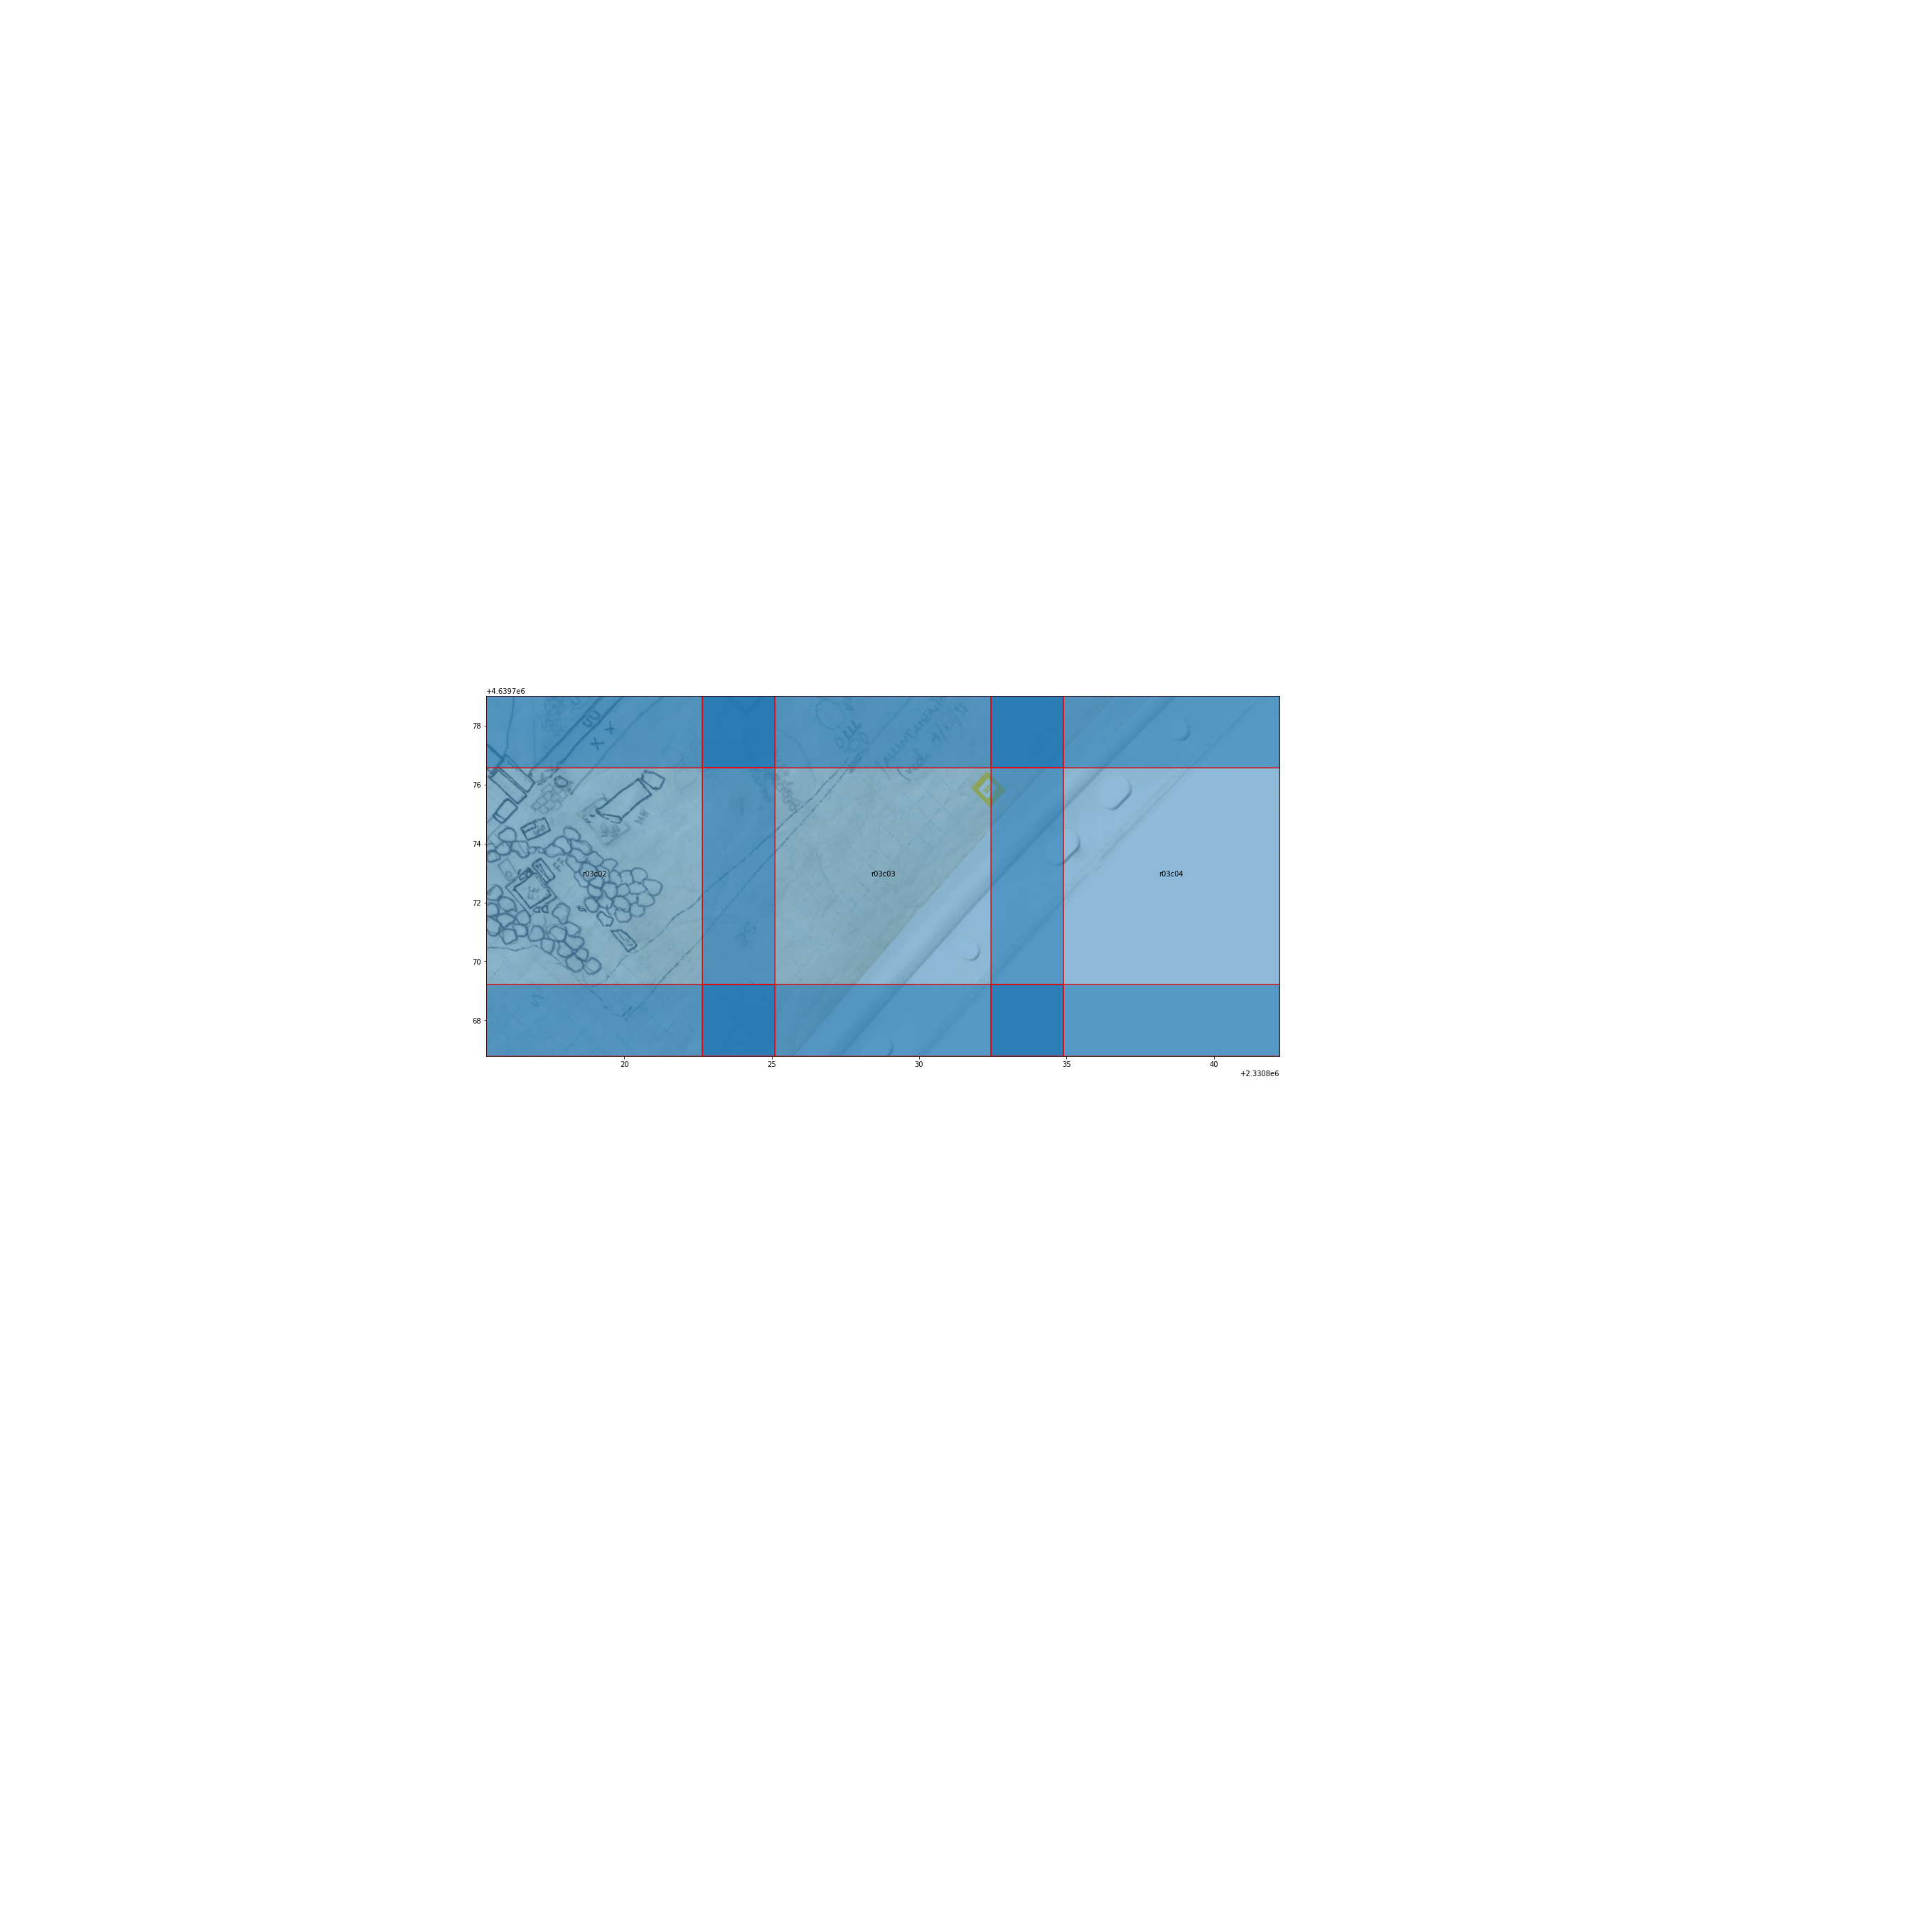

In [50]:
if True:
    if True:          
        tiles = []

        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c03.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c07.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c03.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c07.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c03.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c07.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c03.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c07.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c03.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c04.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c05.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c06.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c07.tif')

        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c00.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c01.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c02.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c03.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c07.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c00.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c01.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c02.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c03.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c07.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c00.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c01.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c02.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c03.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c07.tif')


        tt.plot_tif_and_poly_map5_overlap(tiles)

In [36]:
print(len(tiles))

25
